In [163]:
# libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy 

In [164]:
# read in all CSV files
datasets = os.listdir('../resources/kaggle_data/')
dfs = {}
for file in datasets:
    dfs[file[:-4]] = pd.DataFrame(pd.read_csv(f'../resources/kaggle_data/{file}', encoding='cp1252'))

In [180]:
# # preview all DFs
# df_list = list(dfs.keys())
# for x in df_list:
#     print(x)
#     print(dfs[x])
#     print('\n-----\n')

In [166]:
# create relevant dataframes
seed_df = dfs['MNCAATourneySeeds']
reg_short_df = dfs['MRegularSeasonCompactResults']
tourney_short_df = dfs['MNCAATourneyCompactResults']
reg_long_df = dfs['MRegularSeasonDetailedResults']
tourney_long_df = dfs['MNCAATourneyDetailedResults']
massey_df = dfs['MMasseyOrdinals']
teams_df = dfs['MTeams']
game_cities_df = dfs['MGameCities']
secondary_short_df = dfs['MSecondaryTourneyCompactResults']

In [169]:
avg_massey = massey_df.copy().groupby(['TeamID','Season','RankingDayNum'], as_index=False)['OrdinalRank'].mean()
avg_massey

,TeamID,Season,RankingDayNum,OrdinalRank
0,1101,2014,9,343.928571
1,1101,2014,16,344.533333
2,1101,2014,23,331.277778
3,1101,2014,30,338.888889
4,1101,2014,37,334.843750
...,...,...,...,...
230815,1467,2020,100,208.964286
230816,1467,2020,107,200.224138
230817,1467,2020,114,210.741379
230818,1467,2020,121,212.677966


In [124]:
# # create empty DF to mearge on
# idx = pd.MultiIndex.from_product([avg_massey['TeamID'].unique(),
#                                   avg_massey['Season'].unique(),
#                                   range(134)],
#                                  names=['TeamID','Season','RankingDayNum'])
# col = ['Rank']
# empty_df = pd.DataFrame('-', idx, col)
# empty_df.head()

In [125]:
# full_df = avg_massey.set_index(['TeamID','Season','RankingDayNum'])
# # pd.merge(empty_df, full_df, how='left', on)
# testing_df = full_df.join(empty_df, how='outer').drop(columns='Rank')

# testing_df.sort_index(level=['TeamID','Season','RankingDayNum'])

# testing_df.fillna(method='ffill').fillna(method='bfill')

# testing_df = testing_df.fillna(method='ffill')

# testing_df.loc[testing_df.TeamID==1467]

# testing_df.first_valid_index()


In [179]:
# # append reg season and tourney DFs
# combined_df = reg_short_df.append(tourney_short_df)
# # combined_df = combined_df.append(secondary_short_df)
# # combined_df = combined_df.drop(columns=['SecondaryTourney'])

# merged_cities = pd.merge(combined_df, game_cities_df, 
#                          how='left', 
#                          left_on=['Season','DayNum','WTeamID','LTeamID'],
#                          right_on=['Season','DayNum','WTeamID','LTeamID'])

# merged_cities['CRType'] = merged_cities['CRType'].fillna('Regular')
# merged_cities['CityID'] = merged_cities['CityID'].fillna(0)

# merged_cities

In [178]:
# merged_cities.loc[merged_cities.CityID.notnull()]

In [177]:
# make WLoc column a boolean 
reg_short_df['WLoc'] = reg_short_df['WLoc'].str.replace('H', '1')
reg_short_df['WLoc'] = reg_short_df['WLoc'].str.replace('N', '0')
reg_short_df['WLoc'] = reg_short_df['WLoc'].str.replace('A', '0').astype('int')
reg_short_df['Tourney'] = 0

tourney_short_df['WLoc'] = 0
tourney_short_df['Tourney'] = 1


# append reg season and tourney DFs
combined_df = reg_short_df.append(tourney_short_df)
combined_df['ScoreDiff'] = combined_df['WScore'] - combined_df['LScore']

# create home and away columns based on WLoc
combined_df['HomeTeam'] = np.where(combined_df['WLoc']==1, 
                                   combined_df['WTeamID'], 
                                   combined_df['LTeamID'])

combined_df['AwayTeam'] = np.where(combined_df['WLoc']==0, 
                                   combined_df['WTeamID'], 
                                   combined_df['LTeamID'])

combined_df['ScoreDiff'] = np.where(combined_df['WLoc']==1, 
                                    combined_df['WScore']-combined_df['LScore'], 
                                    combined_df['LScore']-combined_df['WScore'])

combined_df = combined_df.drop(columns=['WTeamID','LTeamID','WScore','LScore','WLoc','NumOT'])

combined_df.head()

,Season,DayNum,Tourney,ScoreDiff,HomeTeam,AwayTeam
0,1985,20,0,-17,1328,1228
1,1985,25,0,7,1106,1354
2,1985,25,0,7,1112,1223
3,1985,25,0,16,1165,1432
4,1985,25,0,12,1192,1447


In [127]:
# merged_df = pd.merge(combined_df, avg_massey, 
#                      how='left', 
#                      left_on=['Season','DayNum','HomeTeam'], 
#                      right_on=['Season','RankingDayNum','TeamID'])\
#             .drop(columns=['TeamID','RankingDayNum'])\
#             .rename(columns={'OrdinalRank':'HomeRank'})
# merged_df

In [128]:
# grouped_df = merged_df.groupby(['HomeTeam','Season', 'DayNum'])['HomeRank'].fillna(method='ffill')
# grouped_df

In [129]:
massey_season_avg = massey_df.groupby(['Season','TeamID'], as_index=False)['OrdinalRank'].mean()

merged_df = pd.merge(combined_df, massey_season_avg, 
                       how='left', 
                       left_on=['Season','HomeTeam'], 
                       right_on=['Season','TeamID'])

merged_df1 = pd.merge(merged_df, massey_season_avg, 
                       how='left', 
                       left_on=['Season','AwayTeam'], 
                       right_on=['Season','TeamID'])

merged_df1 = merged_df1.rename(columns={'OrdinalRank_x':'HomeRankMean','OrdinalRank_y':'AwayRankMean'})\
    .drop(columns=['TeamID_x','TeamID_y'])

merged_df1 = merged_df1.fillna(500)

merged_df1

,Season,DayNum,Tourney,ScoreDiff,HomeTeam,AwayTeam,HomeRankMean,AwayRankMean
0,1985,20,0,-17,1328,1228,500.000000,500.000000
1,1985,25,0,7,1106,1354,500.000000,500.000000
2,1985,25,0,7,1112,1223,500.000000,500.000000
3,1985,25,0,16,1165,1432,500.000000,500.000000
4,1985,25,0,12,1192,1447,500.000000,500.000000
...,...,...,...,...,...,...,...,...
169126,2019,146,1,-6,1246,1120,15.207700,17.748713
169127,2019,146,1,-1,1181,1277,1.980769,6.603239
169128,2019,152,1,-10,1277,1403,6.603239,13.330275
169129,2019,152,1,-1,1120,1438,17.748713,3.682186


In [184]:
# add home team tourney seed column
merged_df2 = pd.merge(merged_df1, seed_df, 
                     how='left', 
                     left_on=['Season','HomeTeam'], 
                     right_on=['Season','TeamID'])\
            .drop(columns=['TeamID'])

merged_df2 = merged_df2.rename(columns={'Seed':'HomeSeed'})


# add away team tourney seed column
merged_df3 = pd.merge(merged_df2, seed_df, 
                     how='left', 
                     left_on=['Season','AwayTeam'], 
                     right_on=['Season','TeamID'])\
            .drop(columns=['TeamID'])

merged_df3 = merged_df3.rename(columns={'Seed':'AwaySeed'})

merged_df3

,Season,DayNum,Tourney,ScoreDiff,HomeTeam,AwayTeam,HomeRankMean,AwayRankMean,HomeSeed,AwaySeed
0,1985,20,0,-17,1328,1228,500.000000,500.000000,Y01,W03
1,1985,25,0,7,1106,1354,500.000000,500.000000,NaN,NaN
2,1985,25,0,7,1112,1223,500.000000,500.000000,X10,NaN
3,1985,25,0,16,1165,1432,500.000000,500.000000,NaN,NaN
4,1985,25,0,12,1192,1447,500.000000,500.000000,Z16,NaN
...,...,...,...,...,...,...,...,...,...,...
169126,2019,146,1,-6,1246,1120,15.207700,17.748713,Y02,Y05
169127,2019,146,1,-1,1181,1277,1.980769,6.603239,W01,W02
169128,2019,152,1,-10,1277,1403,6.603239,13.330275,W02,X03
169129,2019,152,1,-1,1120,1438,17.748713,3.682186,Y05,Z01


In [185]:
merged_df3['HomeSeed'] = merged_df3['HomeSeed'].str.strip().str[1:3]
merged_df3['HomeSeed'] = np.where(len(merged_df3['HomeSeed'])>2, merged_df3['HomeSeed'].str[:2], merged_df3['HomeSeed'])
merged_df3['AwaySeed'] = merged_df3['AwaySeed'].str.strip().str[1:3]
merged_df3['AwaySeed'] = np.where(len(merged_df3['AwaySeed'])>2, merged_df3['AwaySeed'].str[:2], merged_df3['AwaySeed'])

# merged_df3['HomeSeed'] = np.where(merged_df3['Tourney']==1, merged_df3['HomeSeed'], '0')
# merged_df3['AwaySeed'] = np.where(merged_df3['Tourney']==1, merged_df3['AwaySeed'], '0')

merged_df3 = merged_df3.fillna('100')

merged_df3

,Season,DayNum,Tourney,ScoreDiff,HomeTeam,AwayTeam,HomeRankMean,AwayRankMean,HomeSeed,AwaySeed
0,1985,20,0,-17,1328,1228,500.000000,500.000000,01,03
1,1985,25,0,7,1106,1354,500.000000,500.000000,100,100
2,1985,25,0,7,1112,1223,500.000000,500.000000,10,100
3,1985,25,0,16,1165,1432,500.000000,500.000000,100,100
4,1985,25,0,12,1192,1447,500.000000,500.000000,16,100
...,...,...,...,...,...,...,...,...,...,...
169126,2019,146,1,-6,1246,1120,15.207700,17.748713,02,05
169127,2019,146,1,-1,1181,1277,1.980769,6.603239,01,02
169128,2019,152,1,-10,1277,1403,6.603239,13.330275,02,03
169129,2019,152,1,-1,1120,1438,17.748713,3.682186,05,01


In [132]:
merged_df3.AwaySeed.unique()

array(['03', '100', '14', '04', '07', '10', '08', '12', '11', '05', '02',
       '16', '09', '06', '13', '15', '01'], dtype=object)

In [186]:
merged_df3['WinTeam'] = np.where(merged_df3['ScoreDiff']>0, merged_df3['HomeTeam'], merged_df3['AwayTeam'])
merged_df3

,Season,DayNum,Tourney,ScoreDiff,HomeTeam,AwayTeam,HomeRankMean,AwayRankMean,HomeSeed,AwaySeed,WinTeam
0,1985,20,0,-17,1328,1228,500.000000,500.000000,01,03,1228
1,1985,25,0,7,1106,1354,500.000000,500.000000,100,100,1106
2,1985,25,0,7,1112,1223,500.000000,500.000000,10,100,1112
3,1985,25,0,16,1165,1432,500.000000,500.000000,100,100,1165
4,1985,25,0,12,1192,1447,500.000000,500.000000,16,100,1192
...,...,...,...,...,...,...,...,...,...,...,...
169126,2019,146,1,-6,1246,1120,15.207700,17.748713,02,05,1120
169127,2019,146,1,-1,1181,1277,1.980769,6.603239,01,02,1277
169128,2019,152,1,-10,1277,1403,6.603239,13.330275,02,03,1403
169129,2019,152,1,-1,1120,1438,17.748713,3.682186,05,01,1438


In [133]:
# select features and target
merged_df3 = merged_df3.astype({'HomeTeam':'int','AwayTeam':'int',
                                'Season':'int','HomeSeed':'int',
                                'AwaySeed':'int'})
target = merged_df3['ScoreDiff']
selected_features = merged_df3[['Season','DayNum','HomeTeam','AwayTeam','HomeRankMean','AwayRankMean','HomeSeed','AwaySeed']]
print(selected_features.shape)
print(target.shape)

(169131, 8)
(169131,)


In [134]:
# selected_features = pd.get_dummies(selected_features, 
#                prefix=['Season','DayNum','HomeTeam','AwayTeam','HomeSeed','AwaySeed'], 
#                columns=['Season','DayNum','HomeTeam','AwayTeam','HomeSeed','AwaySeed'])
# selected_features

In [135]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

ct = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(), make_column_selector(dtype_include=object))
)

ct.fit_transform(selected_features)

array([[-1.81525516, -1.60582981,  0.40449131, ...,  1.02045611,
        -2.06783856, -2.06783856],
       [-1.81525516, -1.46052908, -1.71903465, ...,  1.02045611,
         0.51948152,  0.51948152],
       [-1.81525516, -1.46052908, -1.66164206, ...,  1.02045611,
         0.51948152,  0.51948152],
       ...,
       [ 1.47751673,  2.23010946, -0.08334574, ..., -1.73409566,
        -2.06783856, -2.06783856],
       [ 1.47751673,  2.23010946, -1.5851186 , ..., -1.78870387,
        -2.12118536, -2.12118536],
       [ 1.47751673,  2.28822975,  1.12189873, ..., -1.78870387,
        -2.12118536, -2.12118536]])

In [136]:
# # Scale data
# from sklearn.preprocessing import MinMaxScaler

# # define min max scaler
# scaler = MinMaxScaler(feature_range=(0, 1))

# # transform data
# X_scaled = scaler.fit_transform(selected_features)

# pd.DataFrame(X_scaled)

In [137]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_features, target, random_state=42)

# Regression testing

In [138]:
# Create the model using LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso

# fit linear regression
lr_model = make_pipeline(ct, LinearRegression())
lr_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90708f9450>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f904ccaa490>)])),
                ('linearregression', LinearRegression())])

In [139]:
def get_model_n_fit(model):
    model_name = type(model).__name__
    model_fit = make_pipeline(ct, model).fit(X_train, y_train)
    return (model_name, model_fit)

In [140]:
models = [
    get_model_n_fit(model)
    for model in [LinearRegression(), ElasticNet(alpha=.01), Ridge(alpha=.01), Lasso(alpha=.01)]
]
models

[('LinearRegression', Pipeline(steps=[('columntransformer',
                   ColumnTransformer(transformers=[('standardscaler',
                                                    StandardScaler(),
                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f90708f9450>),
                                                   ('onehotencoder',
                                                    OneHotEncoder(),
                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f904ccaa490>)])),
                  ('linearregression', LinearRegression())])),
 ('ElasticNet', Pipeline(steps=[('columntransformer',
                   ColumnTransformer(transformers=[('standardscaler',
                                                    StandardScaler(),
                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f90

In [142]:
from sklearn.metrics import mean_squared_error
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
def quantify(model):
    MSE = mean_squared_error(y_test, model.predict(X_test))
    r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    print(f"MSE: {MSE}, Train R2: {r2}, Test R2: {test_r2}")
quantify(lr_model)

MSE: 158.86405817453084, Train R2: 0.27479541227566495, Test R2: 0.2778452078783378


# KNN testing

1
----
3
----
5
----
7
----
9
----
11
----
13
----
15
----
17
----
19
----


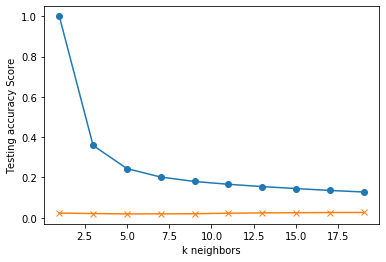

In [24]:
from sklearn.neighbors import KNeighborsClassifier
# Loop through different k values to see which has the highest accuracy
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    print(k)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print('----')
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train, y_train)
print('k=9 Test Acc: %.3f' % knn.score(X_test, y_test))

# SVC testing

In [ ]:
# from sklearn.svm import SVC
# # Create a support vector machine linear classifer and fit it to the training data
# model = SVC(kernel='linear')
# model.fit(X_train, y_train)

In [25]:
from sklearn.svm import SVC

# Print the model score using the test data
svc_model = make_pipeline(ct, SVC(kernel='linear'))
svc_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90d4066390>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90b8170ad0>)])),
                ('svc', SVC(kernel='linear'))])

In [26]:
# Calculate the classification report
from sklearn.metrics import classification_report
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         -84       0.00      0.00      0.00         1
         -66       0.00      0.00      0.00         1
         -60       0.00      0.00      0.00         0
         -59       0.00      0.00      0.00         0
         -55       0.00      0.00      0.00         1
         -54       0.00      0.00      0.00         1
         -53       0.00      0.00      0.00         4
         -52       0.00      0.00      0.00         3
         -51       0.00      0.00      0.00         5
         -50       0.00      0.00      0.00         3
         -49       0.00      0.00      0.00         1
         -48       0.00      0.00      0.00         1
         -47       0.00      0.00      0.00         5
         -46       0.00      0.00      0.00         3
         -45       0.00      0.00      0.00         4
         -44       0.00      0.00      0.00        12
         -43       0.00      0.00      0.00         7
         -42       0.00    

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TODO:

In [ ]:
## idea
df_columns = [
           'Season','Day','RegOrTourney',
           'HomeTeam','HomeTeamRank1',...,'HomeTeamSeed',
           'AwayTeam','AwayTeamRank1',...,'AwayTeamSeed',
           'WLoc'
          ]

In [ ]:
seed_df.head()

In [ ]:
reg_short_df.head()

In [ ]:
tourney_short_df.head()

In [ ]:
reg_long_df

In [ ]:
tourney_long_df.head()

In [ ]:
massey_df

In [ ]:
merged_df = pd.merge(
     reg_short_df, massey_df, 
     how='left', 
     left_on=['Season','DayNum','WTeamID'], 
     right_on=['Season','RankingDayNum','TeamID']
)

# pd.merge(A_df, B_df,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])

In [ ]:
merged_df

In [ ]:
merged_df = pd.merge(
     reg_short_df, massey_df, 
     how='left', 
     left_on=['Season','DayNum','WTeamID'], 
     right_on=['Season','RankingDayNum','TeamID']
).rename(columns={'TeamID':'WinID'})

merged_df

In [ ]:
merged_df = pd.merge(
     merged_df, massey_df, 
     how='left', 
     left_on=['Season','DayNum','LTeamID'], 
     right_on=['Season','RankingDayNum','TeamID']
).rename(columns={
    'TeamID':'LoseID','RankingDayNum_x':'RankingDayNum','OrdinalRank_x':'WinRank',
    'OrdinalRank_y':'LoseRank','SystemName_x':'WinSystem','SystemName_y':'LoseSystem'
}).drop(columns=['RankingDayNum_y'])

merged_df

In [ ]:
reg_short_df